In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

In [3]:
data = pd.read_csv('./data/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
address2country = pd.read_csv('./data/IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:
# Convertir l'adresse IP en valeur numérique
data['ip_address_num'] = data['ip_address'].astype(float)

# Fusionner les deux DataFrames
data_merged = pd.merge_asof(data.sort_values('ip_address_num'), 
                            address2country.sort_values('lower_bound_ip_address'),
                            left_on='ip_address_num',
                            right_on='lower_bound_ip_address',
                            direction='backward')

# Supprimer les colonnes inutiles
data_merged = data_merged.drop(['ip_address_num', 'lower_bound_ip_address', 'upper_bound_ip_address'], axis=1)

# Afficher les 5 premières lignes
data_merged.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093.496895,0,NaN
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447.138961,0,NaN
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818.501505,0,NaN
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566.664867,0,NaN
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423.789042,0,NaN


In [8]:
# Calculer la différence de temps
data_merged['time_diff'] = data_merged['purchase_time'] - data_merged['signup_time']

# Convertir la différence en heures
data_merged['time_diff_hours'] = data_merged['time_diff'].dt.total_seconds() / 3600

# Afficher les 5 premières lignes pour vérifier
print(data_merged[['signup_time', 'purchase_time', 'time_diff', 'time_diff_hours']].head())


          signup_time       purchase_time        time_diff  time_diff_hours
0 2015-02-16 00:17:05 2015-03-08 10:00:39 20 days 09:43:34       489.726111
1 2015-03-08 04:03:22 2015-03-20 17:23:45 12 days 13:20:23       301.339722
2 2015-05-17 16:45:54 2015-05-26 08:54:34  8 days 16:08:40       208.144444
3 2015-03-03 19:58:39 2015-05-28 21:09:13 86 days 01:10:34      2065.176111
4 2015-03-20 00:31:27 2015-04-05 07:31:46 16 days 07:00:19       391.005278


Top 10 appareils avec le plus grand nombre d'utilisateurs uniques :
device_id
CQTUVBYIWWWBC    20
ITUMJCKWEYNDD    20
NGQCKIADMZORL    20
EQYVNEGOFLAWK    20
KIPFSCNUGOLDP    20
ZUSVMDEZRBDTX    20
EGLGSEGYPMMAM    19
CDFXVYHOIHPYP    19
SDJQRPKXQFBED    19
BWSMVSLCJXMCM    19
Name: user_id, dtype: int64

Nombre total d'appareils uniques : 137956
Nombre d'appareils avec plusieurs utilisateurs : 6175
Pourcentage d'appareils avec plusieurs utilisateurs : 4.48%


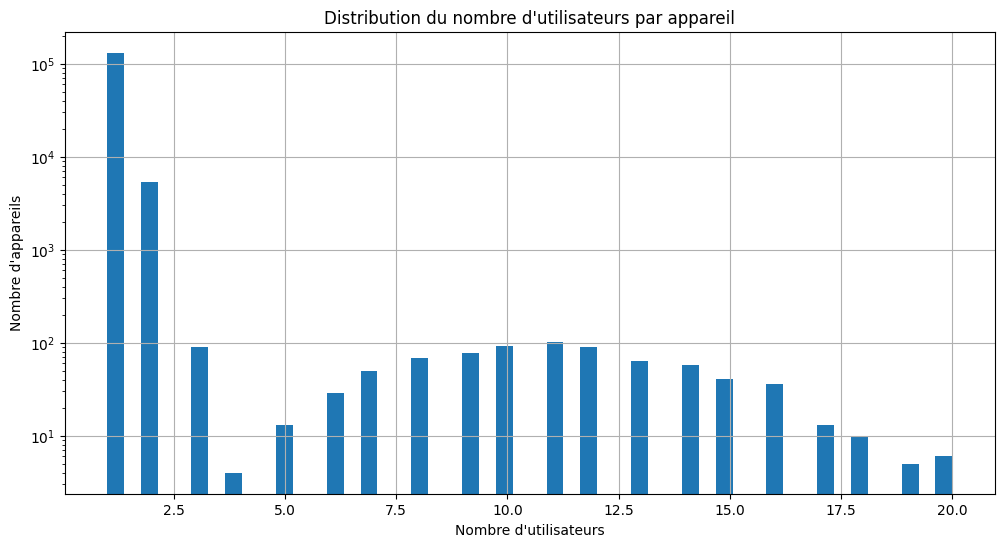

In [9]:
# Compter le nombre d'utilisateurs par appareil
device_user_count = data_merged.groupby('device_id')['user_id'].nunique().sort_values(ascending=False)

# Afficher les 10 premiers appareils avec le plus grand nombre d'utilisateurs
print("Top 10 appareils avec le plus grand nombre d'utilisateurs uniques :")
print(device_user_count.head(10))

# Calculer quelques statistiques
total_devices = len(device_user_count)
devices_with_multiple_users = (device_user_count > 1).sum()
percentage_multiple_users = (devices_with_multiple_users / total_devices) * 100

print(f"\nNombre total d'appareils uniques : {total_devices}")
print(f"Nombre d'appareils avec plusieurs utilisateurs : {devices_with_multiple_users}")
print(f"Pourcentage d'appareils avec plusieurs utilisateurs : {percentage_multiple_users:.2f}%")

# Créer un histogramme pour visualiser la distribution
plt.figure(figsize=(12, 6))
device_user_count.hist(bins=50)
plt.title("Distribution du nombre d'utilisateurs par appareil")
plt.xlabel("Nombre d'utilisateurs")
plt.ylabel("Nombre d'appareils")
plt.yscale('log')  # Échelle logarithmique pour mieux visualiser
plt.show()


          signup_time signup_day  signup_week       purchase_time  \
0 2015-02-16 00:17:05      Lundi            8 2015-03-08 10:00:39   
1 2015-03-08 04:03:22   Dimanche           10 2015-03-20 17:23:45   
2 2015-05-17 16:45:54   Dimanche           20 2015-05-26 08:54:34   
3 2015-03-03 19:58:39      Mardi           10 2015-05-28 21:09:13   
4 2015-03-20 00:31:27   Vendredi           12 2015-04-05 07:31:46   

  purchase_day  purchase_week  
0     Dimanche             10  
1     Vendredi             12  
2        Mardi             22  
3        Jeudi             22  
4     Dimanche             14  


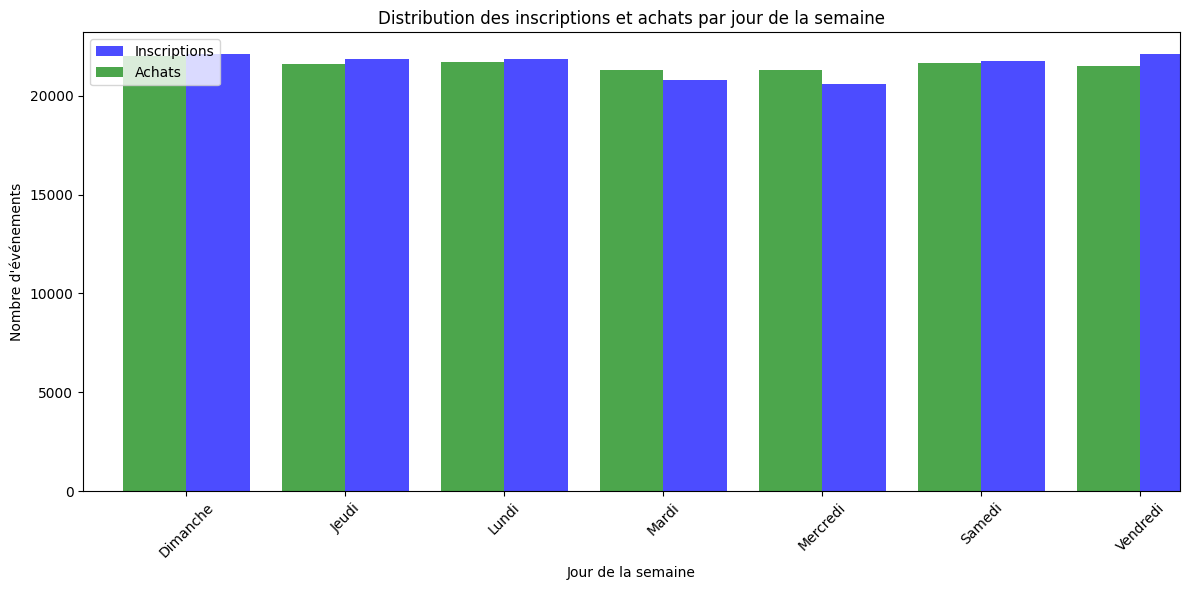

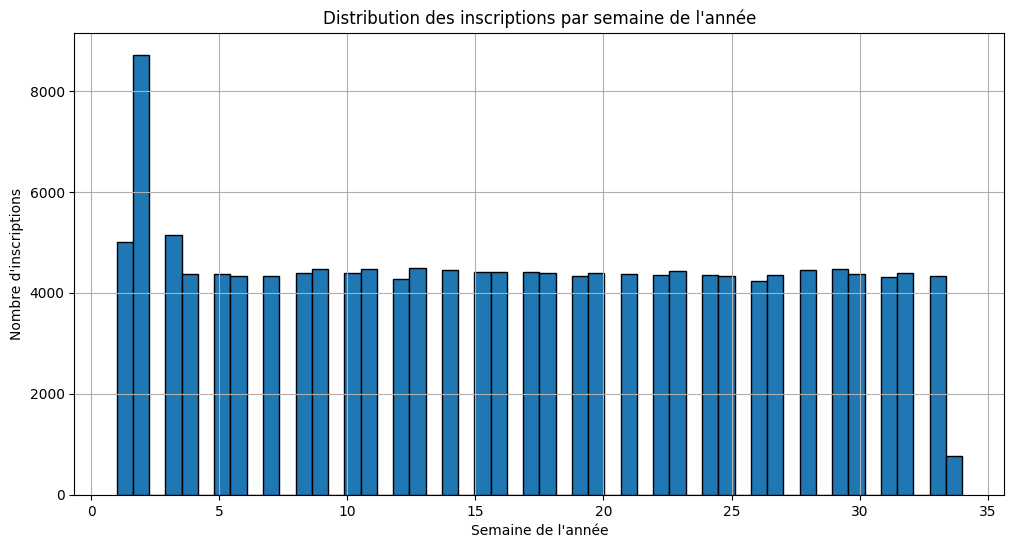

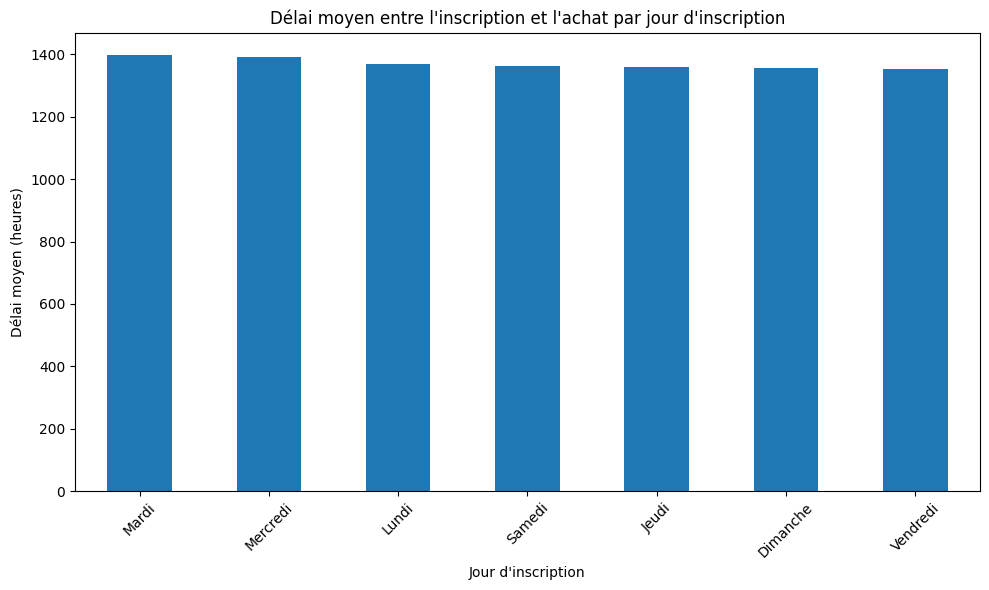

Délai moyen entre l'inscription et l'achat par jour d'inscription :
signup_day
Mardi       1399.076708
Mercredi    1392.777923
Lundi       1369.286170
Samedi      1362.171232
Jeudi       1359.171439
Dimanche    1356.549450
Vendredi    1354.046187
Name: time_diff_hours, dtype: float64


In [10]:
# Fonction pour obtenir le nom du jour en français
def get_french_day_name(day_number):
    days = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
    return days[day_number]

# Extraire les informations de jour et de semaine pour signup_time et purchase_time
data_merged['signup_day'] = data_merged['signup_time'].dt.dayofweek.apply(get_french_day_name)
data_merged['signup_week'] = data_merged['signup_time'].dt.isocalendar().week
data_merged['purchase_day'] = data_merged['purchase_time'].dt.dayofweek.apply(get_french_day_name)
data_merged['purchase_week'] = data_merged['purchase_time'].dt.isocalendar().week

# Afficher les premières lignes pour vérifier
print(data_merged[['signup_time', 'signup_day', 'signup_week', 'purchase_time', 'purchase_day', 'purchase_week']].head())

# Analyser la distribution des inscriptions par jour de la semaine
signup_day_counts = data_merged['signup_day'].value_counts().sort_index()
purchase_day_counts = data_merged['purchase_day'].value_counts().sort_index()

# Créer un graphique pour visualiser les inscriptions et achats par jour de la semaine
plt.figure(figsize=(12, 6))
signup_day_counts.plot(kind='bar', position=0, width=0.4, color='blue', alpha=0.7, label='Inscriptions')
purchase_day_counts.plot(kind='bar', position=1, width=0.4, color='green', alpha=0.7, label='Achats')
plt.title("Distribution des inscriptions et achats par jour de la semaine")
plt.xlabel("Jour de la semaine")
plt.ylabel("Nombre d'événements")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyser la distribution des inscriptions par semaine
plt.figure(figsize=(12, 6))
data_merged['signup_week'].hist(bins=52, edgecolor='black')
plt.title("Distribution des inscriptions par semaine de l'année")
plt.xlabel("Semaine de l'année")
plt.ylabel("Nombre d'inscriptions")
plt.show()

# Calculer le délai moyen entre l'inscription et l'achat pour chaque jour de la semaine
avg_delay_by_day = data_merged.groupby('signup_day')['time_diff_hours'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
avg_delay_by_day.plot(kind='bar')
plt.title("Délai moyen entre l'inscription et l'achat par jour d'inscription")
plt.xlabel("Jour d'inscription")
plt.ylabel("Délai moyen (heures)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Délai moyen entre l'inscription et l'achat par jour d'inscription :")
print(avg_delay_by_day)


In [13]:
# Ajouter les colonnes de jours et semaines
data_merged['signup_day'] = data_merged['signup_time'].dt.dayofweek
data_merged['signup_week'] = data_merged['signup_time'].dt.isocalendar().week
data_merged['purchase_day'] = data_merged['purchase_time'].dt.dayofweek
data_merged['purchase_week'] = data_merged['purchase_time'].dt.isocalendar().week

# Calculer la différence de temps en heures
data_merged['time_diff'] = data_merged['purchase_time'] - data_merged['signup_time']
data_merged['time_diff_hours'] = data_merged['time_diff'].apply(lambda x: x.total_seconds() / 3600)

# Afficher les premières lignes du DataFrame mis à jour
data_merged[['user_id', 'signup_time', 'purchase_time', 'signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'time_diff_hours']].head()


,user_id,signup_time,purchase_time,signup_day,signup_week,purchase_day,purchase_week,time_diff_hours
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,0,8,6,10,489.726111
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,6,10,4,12,301.339722
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,6,20,1,22,208.144444
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,1,10,3,22,2065.176111
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,4,12,6,14,391.005278
